# DA2 - ESC-50 Classification
Goutham Krishnan 21BAI1007

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import seaborn as sns
import librosa
import librosa.display

### Data Analysis and Visualizations

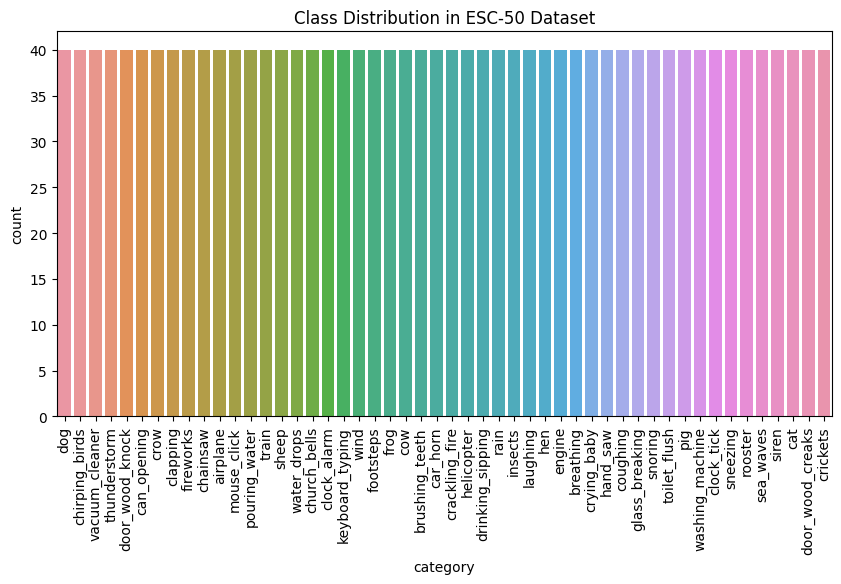

Sample Data:
             filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A


In [11]:
# Load the dataset CSV
esc50_csv_path = '/kaggle/input/environmental-sound-classification-50/esc50.csv'
esc50_data = pd.read_csv(esc50_csv_path)

# Display class distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=esc50_data, x='category', order=esc50_data['category'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Class Distribution in ESC-50 Dataset")
plt.show()

# Print a sample row
print("Sample Data:\n", esc50_data.head())

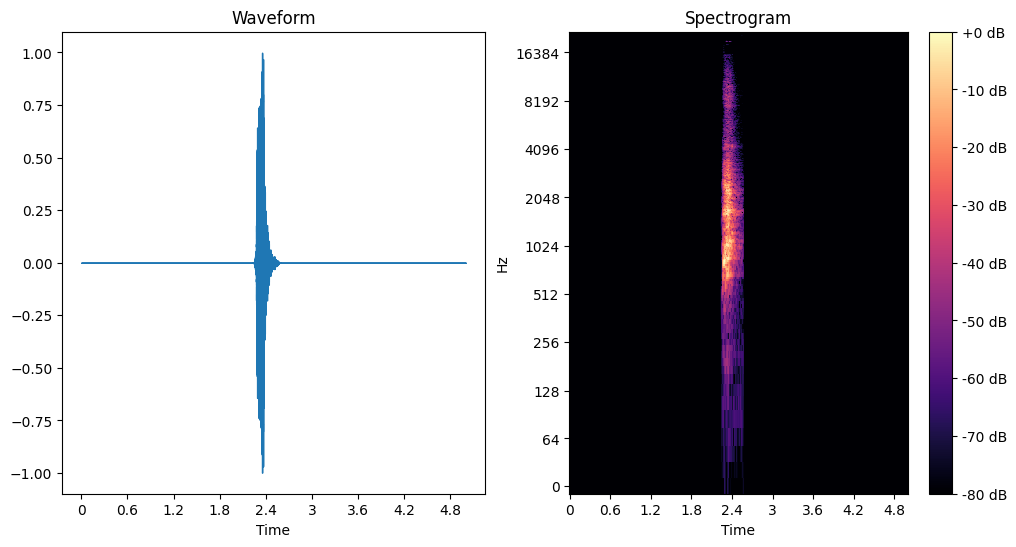

In [12]:
## Visualizing an Audio File
def visualize_audio(filename):
    # Load audio file
    audio, sr = librosa.load(filename, sr=None)
    plt.figure(figsize=(12, 6))
    
    # Waveform
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.title("Waveform")
    
    # Spectrogram
    plt.subplot(1, 2, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Spectrogram")
    
    plt.show()

# Visualize a random sample
sample_file = os.path.join("/kaggle/input/environmental-sound-classification-50/audio/audio", esc50_data.loc[0, 'filename'])
visualize_audio(sample_file)

### Classification model and Feature Exraction

/tmp/ipykernel_30/2506168450.py:343: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))


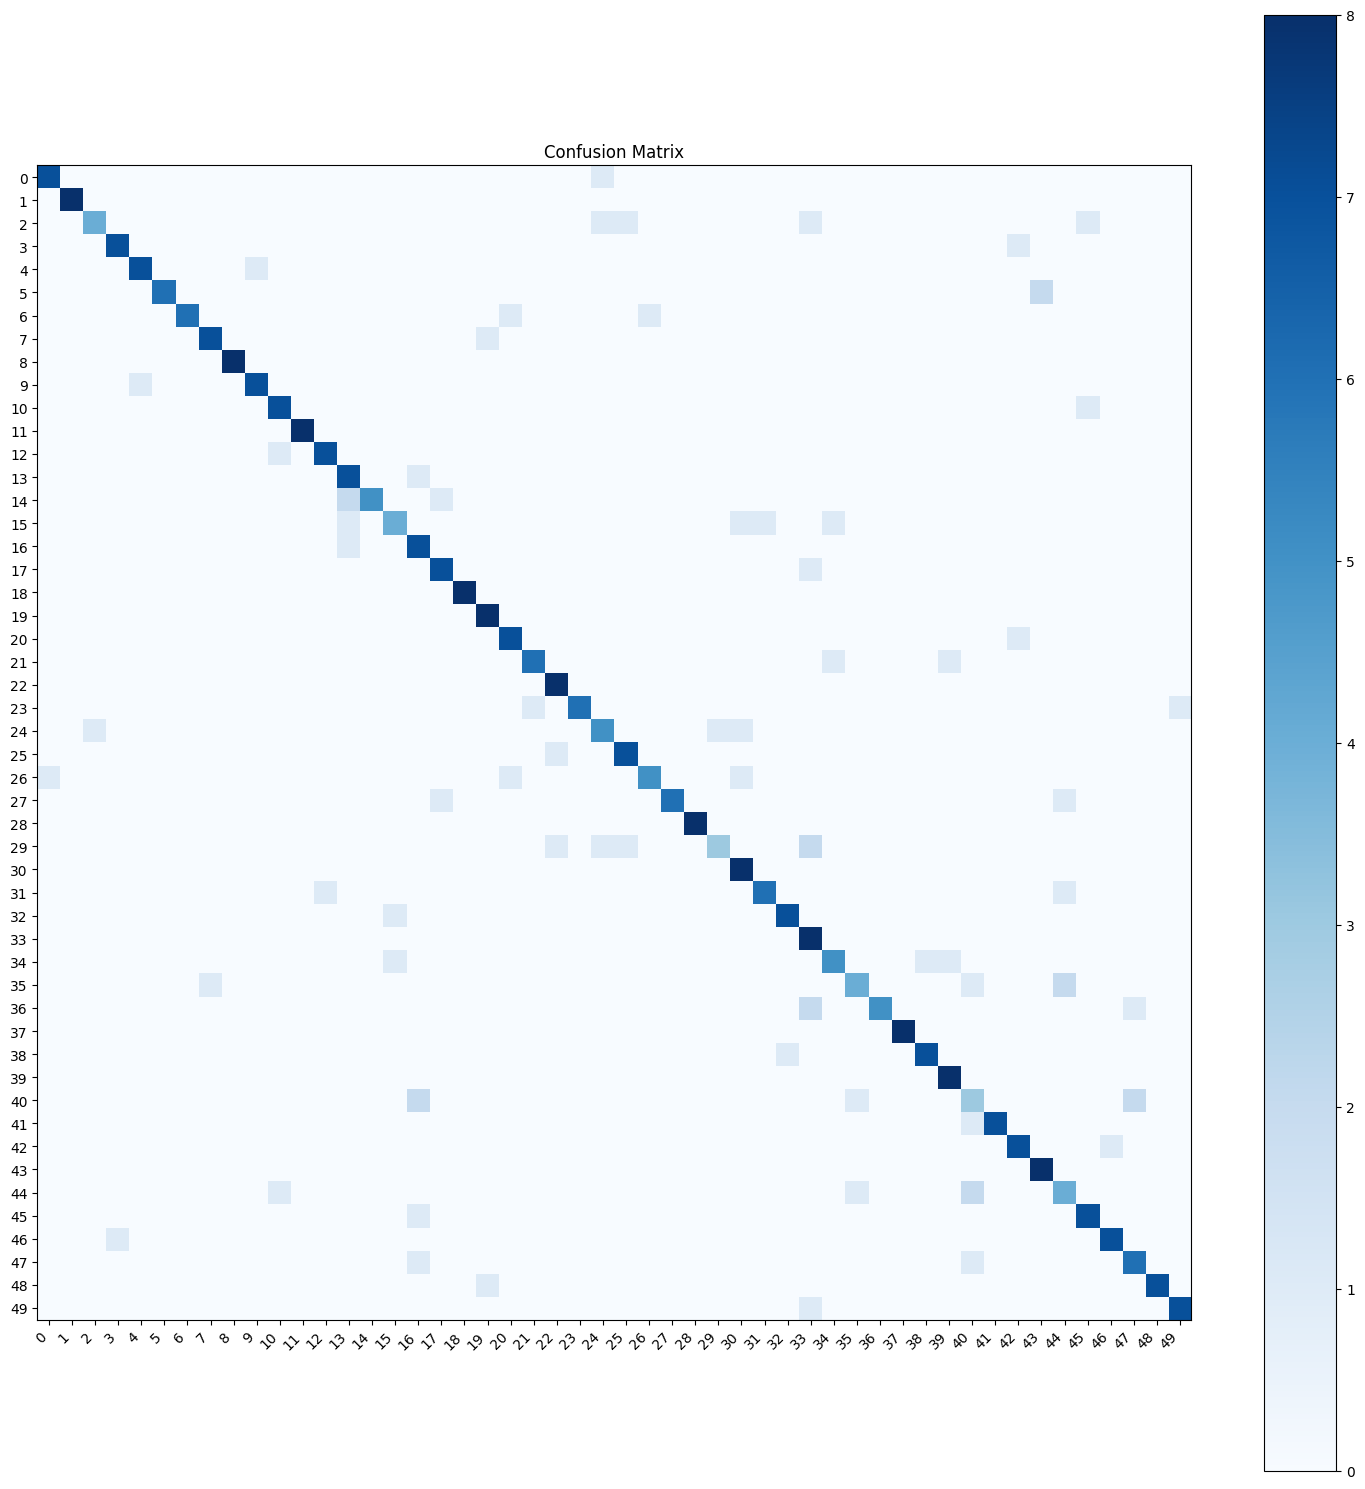


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       1.00      1.00      1.00         8
           2       0.80      0.50      0.62         8
           3       0.88      0.88      0.88         8
           4       0.88      0.88      0.88         8
           5       1.00      0.75      0.86         8
           6       1.00      0.75      0.86         8
           7       0.88      0.88      0.88         8
           8       1.00      1.00      1.00         8
           9       0.88      0.88      0.88         8
          10       0.78      0.88      0.82         8
          11       1.00      1.00      1.00         8
          12       0.88      0.88      0.88         8
          13       0.64      0.88      0.74         8
          14       1.00      0.62      0.77         8
          15       0.67      0.50      0.57         8
          16       0.58      0.88      0.70         8
   

In [8]:


class AudioDataset(Dataset):
    def __init__(self, audio_dir, metadata_path, transform=None):
      
        self.audio_dir = audio_dir
        self.metadata = pd.read_csv(metadata_path)
        self.transform = transform
        
        # Audio processing parameters
        self.sample_rate = 16000
        self.num_samples = 5 * self.sample_rate  
        
        # Mel spectrogram parameters
        self.mel_spec_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_fft=1024,
            hop_length=512,
            n_mels=64
        )
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        audio_path = os.path.join(self.audio_dir, self.metadata.iloc[idx]['filename'])
        label = self.metadata.iloc[idx]['target']
        
        # Load audio
        waveform, sample_rate = torchaudio.load(audio_path)
        
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Resample if necessary
        if sample_rate != self.sample_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, self.sample_rate)
            waveform = resampler(waveform)
        
        # Ensure constant length
        if waveform.shape[1] < self.num_samples:
            # Pad if too short
            waveform = F.pad(waveform, (0, self.num_samples - waveform.shape[1]))
        else:
            # Random crop if too long
            start = torch.randint(0, waveform.shape[1] - self.num_samples + 1, (1,))
            waveform = waveform[:, start:start + self.num_samples]
        
        # Convert to mel spectrogram
        mel_spec = self.mel_spec_transform(waveform)
        
        # Convert to decibels
        mel_spec = torchaudio.transforms.AmplitudeToDB()(mel_spec)
        
        mel_spec = (mel_spec - mel_spec.mean()) / mel_spec.std()
        
        if self.transform:
            mel_spec = self.transform(mel_spec)
        
        return mel_spec, label

class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.3)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout(0.3)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2)
        self.dropout4 = nn.Dropout(0.3)
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        self._to_linear = 256 * 4 * 4
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.dropout5 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout4(x)
        
        x = self.adaptive_pool(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = self.fc2(x)
        
        return x
        
  

class AudioClassifier:
    def __init__(self, audio_dir, metadata_path, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.audio_dir = audio_dir
        self.metadata_path = metadata_path
        self.dataset = AudioDataset(audio_dir, metadata_path)
        self.num_classes = 50
        self.model = AudioCNN(self.num_classes).to(self.device)
        
    def train(self, batch_size=32, num_epochs=50, learning_rate=0.001):
        # Split dataset
        train_idx, val_idx = train_test_split(
            np.arange(len(self.dataset)),
            test_size=0.2,
            stratify=self.dataset.metadata['target']
        )
        
        train_dataset = torch.utils.data.Subset(self.dataset, train_idx)
        val_dataset = torch.utils.data.Subset(self.dataset, val_idx)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5)
        
        # Training history
        history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        
        best_val_acc = 0.0
        
        for epoch in range(num_epochs):
            # Training 
            self.model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
            for inputs, labels in pbar:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                
                pbar.set_postfix({'loss': train_loss/train_total, 
                                'acc': 100.*train_correct/train_total})
            
            # Validation 
            self.model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.model(inputs)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
            
            epoch_train_loss = train_loss/len(train_loader)
            epoch_train_acc = 100.*train_correct/train_total
            epoch_val_loss = val_loss/len(val_loader)
            epoch_val_acc = 100.*val_correct/val_total
            
            scheduler.step(epoch_val_acc)
            
            # Save best model
            if epoch_val_acc > best_val_acc:
                best_val_acc = epoch_val_acc
                torch.save(self.model.state_dict(), 'best_model.pth')
            
            history['train_loss'].append(epoch_train_loss)
            history['train_acc'].append(epoch_train_acc)
            history['val_loss'].append(epoch_val_loss)
            history['val_acc'].append(epoch_val_acc)
            
            print(f'\nEpoch {epoch+1}/{num_epochs}:')
            print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
            print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
        
        return history
    
    def plot_training_history(self, history):
        plt.figure(figsize=(12, 4))
        
        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Train Accuracy')
        plt.plot(history['val_acc'], label='Val Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def evaluate(self, batch_size=32):

        _, val_idx = train_test_split(
            np.arange(len(self.dataset)),
            test_size=0.2,
            stratify=self.dataset.metadata['target']
        )
        
        val_dataset = torch.utils.data.Subset(self.dataset, val_idx)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        self.model.eval()
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.numpy())
        
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)
        
        # Plot confusion matrix
        plt.figure(figsize=(15, 15))
        cm = pd.crosstab(
            pd.Series(all_labels, name='Actual'),
            pd.Series(all_predictions, name='Predicted')
        )
        plt.imshow(cm, cmap='Blues')
        plt.colorbar()
        plt.xticks(range(len(cm.columns)), cm.columns, rotation=45, ha='right')
        plt.yticks(range(len(cm.index)), cm.index)
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()
        
        # Print classification report
        from sklearn.metrics import classification_report
        print("\nClassification Report:")
        print(classification_report(
            all_labels,
            all_predictions,
            # target_names=self.dataset.label_encoder.classes_
        ))


classifier = AudioClassifier(
    audio_dir='/kaggle/input/environmental-sound-classification-50/audio/audio/44100',
    metadata_path='/kaggle/input/environmental-sound-classification-50/esc50.csv'
)

## Loading the model since the model was trained and the weights were saved earlier

# # Train the model
# history = classifier.train(batch_size=32, num_epochs=50)

# # Plot training history
# classifier.plot_training_history(history)

classifier.model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))

# Evaluate the model
classifier.evaluate()